In [1]:
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive to access datasets and save models

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
# Load the merged and labeled vibration dataset (4096-point windows)
file_path = '/content/drive/MyDrive/SAYZEK/beginning/combined_trainingrawdata.csv'
df = pd.read_csv(file_path)

In [5]:
df.tail()

,DE_0001,DE_0002,DE_0003,DE_0004,DE_0005,DE_0006,DE_0007,DE_0008,DE_0009,DE_0010,...,DE_4088,DE_4089,DE_4090,DE_4091,DE_4092,DE_4093,DE_4094,DE_4095,DE_4096,Label
3422,0.772429,0.134321,-0.529778,-1.109404,-1.508383,-1.691628,-1.583761,-1.222469,-0.590860,0.208399,...,-0.091810,0.012158,0.101831,0.159014,0.178508,0.191504,0.213597,0.214897,0.179808,Outer
3423,0.094033,-0.016433,-0.100908,-0.154192,-0.176285,-0.207476,-0.247763,-0.263359,-0.234767,-0.172386,...,-0.407615,-0.338736,-0.213974,-0.050223,0.104430,0.239590,0.344858,0.426733,0.457924,Outer
3424,0.422834,0.330562,0.200601,0.078438,-0.024231,-0.110005,-0.167188,-0.197079,-0.189281,-0.126900,...,-0.028130,0.023855,0.090135,0.148617,0.160313,0.148617,0.118726,0.087535,0.069341,Outer
3425,0.032952,-0.034628,-0.107406,-0.173686,-0.219172,-0.238666,-0.249063,-0.263359,-0.281553,-0.275055,...,-0.230869,-0.169787,-0.054122,0.081037,0.190204,0.269481,0.281177,0.257784,0.225294,Outer
3426,0.149917,0.055045,-0.054122,-0.141196,-0.159390,-0.135997,-0.072316,-0.012534,0.031652,0.094033,...,0.026454,0.074539,0.133022,0.164212,0.172010,0.135621,0.068041,0.005660,-0.058021,Outer


In [6]:
# Separate input features (X) and target labels (Y)
X = df.iloc[:, :4096].values  # First 4096 columns contain signal data
Y = df['Label'].values        # Last column contains the class labels

# Print the shapes to verify the datas
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (3427, 4096)
Y shape: (3427,)


In [18]:
# Define sampling frequency and time vector
sampling_freq = 24000  # Hz
numofsamples = 4096
time = np.linspace(0, numofsamples / sampling_freq, numofsamples)

# Compute FFT for all samples
X = np.abs(np.fft.fft(X))  # Changed: Take magnitude to convert complex to real

df2 = pd.DataFrame(X)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.036611e+07,1.938651e+07,2.219876e+07,1.174570e+07,4.331845e+06,1.765021e+07,2.141755e+07,1.807470e+07,1.499715e+07,1.584613e+07,...,3.319714e+07,4.014816e+07,2.842163e+07,1.611143e+07,3.482866e+06,9.517128e+06,2.336610e+07,3.631304e+07,3.970895e+07,3.413753e+07
1,1.354978e+07,1.122980e+07,2.592775e+07,2.757265e+07,1.409511e+07,1.664070e+06,1.583141e+07,2.633753e+07,3.482732e+07,4.241507e+07,...,2.740009e+06,1.956041e+07,3.839714e+07,5.049509e+07,5.256448e+07,3.898081e+07,2.348694e+07,1.054001e+07,3.415090e+06,1.487631e+07
2,2.623141e+07,2.936202e+07,1.949263e+07,1.451826e+06,1.743796e+07,2.651143e+07,2.529102e+07,1.658898e+07,5.605314e+06,6.015089e+06,...,1.365590e+07,2.283549e+07,3.031712e+07,3.254569e+07,2.628447e+07,1.423958e+07,2.778356e+06,4.583776e+05,1.625724e+06,4.437968e+06
3,4.756335e+06,2.103275e+06,8.402843e+06,1.572529e+07,1.837835e+07,9.251822e+06,9.691027e+06,2.062163e+07,2.428286e+07,1.902980e+07,...,5.006926e+06,3.521213e+06,2.566111e+06,5.749783e+06,1.689264e+07,2.188039e+07,1.280692e+07,1.360418e+06,1.314000e+07,1.340531e+07
4,7.091028e+06,2.686948e+06,7.089688e+05,1.770193e+06,7.235497e+06,2.219876e+07,3.350079e+07,2.766406e+07,1.036611e+07,6.772661e+06,...,6.545701e+06,1.498243e+07,1.874978e+07,1.620284e+07,4.688559e+06,4.597151e+06,1.080397e+06,6.651823e+06,9.570190e+06,7.766109e+06


In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3427 entries, 0 to 3426
Columns: 4096 entries, 0 to 4095
dtypes: float64(4096)
memory usage: 107.1 MB


In [20]:
import joblib

encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)      # Convert string labels to integer indices
OHE_Y = to_categorical(encoded_Y)         # One-hot encode the integer labels

# Save the encoder to disk to use it later during inference
joblib.dump(encoder, '/content/drive/MyDrive/SAYZEK/beginning/encoder.pkl')

# Check the shape of the one-hot encoded labels
print("Encoded Y shape:", OHE_Y.shape)


Encoded Y shape: (3427, 4)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(df2, OHE_Y, test_size=0.2, stratify=Y, random_state=42)

# Normalize input features (standard scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit the scaler only on training data
X_test = scaler.transform(X_test)        # Use the same scaler on test data

# Save the fitted scaler for future use
joblib.dump(scaler, '/content/drive/MyDrive/SAYZEK/beginning/scaler.pkl')

# Reshape input data to match Conv1D input requirements: (samples, time_steps, 1 channel)
X_train = X_train.reshape(-1, 4096).transpose(0, 1)
X_test = X_test.reshape(-1, 4096).transpose(0, 1)

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2741, 4096)
X_test shape: (686, 4096)
y_train shape: (2741, 4)
y_test shape: (686, 4)


In [22]:
model = Sequential()

# First 1D Convolutional Layer with 64 filters and ReLU activation
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(4096,1), padding='same'))
model.add(BatchNormalization())          # Normalize activations
model.add(MaxPooling1D(pool_size=2))     # Downsample by factor of 2
model.add(Dropout(0.3))                  # Dropout to prevent overfitting

# Second 1D Convolutional Layer with 128 filters
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully connected layer with ReLU activation
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout before final output layer

# Output layer with softmax activation for multi-class classification
model.add(Dense(len(encoder.classes_), activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4096, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2048, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2048, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,803,588 (64.10 MB)

 Trainable params: 16,803,204 (64.10 MB)

 Non-trainable params: 384 (1.50 KB)

In [23]:
# Define training parameters
batch_size = 128
epochs = 500

# Train the model with validation data
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    shuffle=True,   # Shuffle training data every epoch
    verbose=1       # Show training progress
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 331ms/step - accuracy: 0.4771 - loss: 8.7429 - val_accuracy: 0.2230 - val_loss: 12.4083
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5540 - loss: 0.9601 - val_accuracy: 0.1633 - val_loss: 23.7846
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6758 - loss: 0.7715 - val_accuracy: 0.1531 - val_loss: 33.1648
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.6850 - loss: 0.6955 - val_accuracy: 0.1312 - val_loss: 38.7434
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7011 - loss: 0.6184 - val_accuracy: 0.1239 - val_loss: 43.8570
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7396 - loss: 0.5916 - val_accuracy: 0.1166 - val_loss: 48.6131
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7693 - loss: 0.5756 - val_accuracy: 0.1399 - val_loss: 49.3776
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7684 - loss: 0.4905 - val_acc

In [24]:
print("Model input shape:", model.input_shape)

Model input shape: (None, 4096, 1)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8106 - loss: 1.6134
Test Accuracy: 82.22%
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


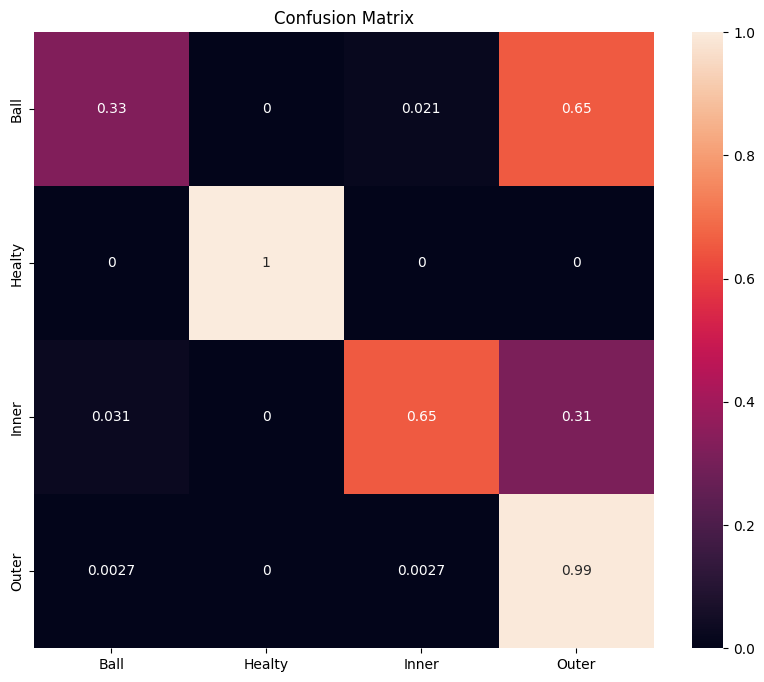

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert one-hot predictions to class indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Generate a normalized confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')

# Plot the confusion matrix for better visualization of class performance
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.show()
